In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from tqdm import tqdm
from pathlib import Path

/home/oyilmazel_umass_edu/.conda/envs/ytb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transcript_dir = Path("/work/pi_vcpartridge_umass_edu/ytb_csv/")
df = pd.read_csv(transcript_dir / "transcripts_normalized.csv", header=0)
df.dropna(subset=["transcript"], inplace=True)
df.head()

,video_id,transcript
0,AAHiZ-c88ec,man im getting frustrated water heater deliver...
1,AEsRr-ZnzNc,start give shout rokukun vyonder harrystack go...
2,AJpzk-aFZPU,10 minute test number exploding apple alright ...
3,AONXX-h9SdI,gonna play something brand new album came octo...
5,APerX-RLJxo,2010 toyota corolla fourdoor sedan automatic t...


In [3]:
def get_kmeans_clusters(X_embeddings: np.ndarray, n_clusters: int = 10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_embeddings)
    return kmeans

In [4]:
cluster_sizes = list(range(10, 30))
df_all = df.copy()
df_less_than_100 = df[df["transcript"].str.split().str.len() < 100]
df_more_than_100 = df[df["transcript"].str.split().str.len() >= 100]

df_corporas = [df_all, df_less_than_100, df_more_than_100]
print(df_corporas[0].shape)
print(df_corporas[1].shape)
print(df_corporas[2].shape)

(2316, 2)
(1142, 2)
(1174, 2)


In [5]:
measures = [[], [], []]
kms = [[], [], []]

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# save embeddings once
print("Embedding transcripts...")
df_embeddings = []
for df_corpus in tqdm(df_corporas):
    embeddings = model.encode(df_corpus["transcript"].to_list(), convert_to_numpy=True)
    df_embeddings.append(embeddings)

print("Clustering transcripts...")
for n_clusters in tqdm(cluster_sizes):
    for i, df_corpus in enumerate(df_corporas):
        km = get_kmeans_clusters(df_embeddings[i], n_clusters)
        kms[i].append(km)
        measures[i].append({
            "n_clusters": n_clusters,
            "inertia": km.inertia_,
            "silhouette_score": silhouette_score(df_embeddings[i], km.labels_),
            "davies_bouldin_score": davies_bouldin_score(df_embeddings[i], km.labels_),
            "calinski_harabasz_score": calinski_harabasz_score(df_embeddings[i], km.labels_)
        })

Embedding transcripts...


100%|██████████| 3/3 [00:53<00:00, 17.96s/it]


Clustering transcripts...


100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


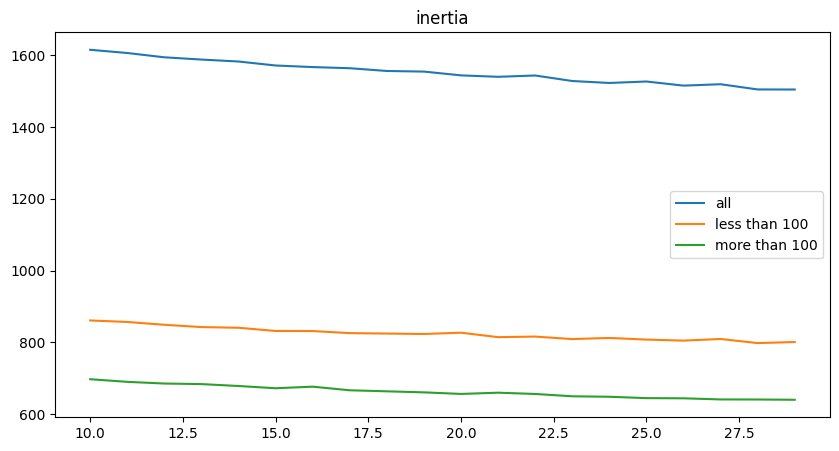

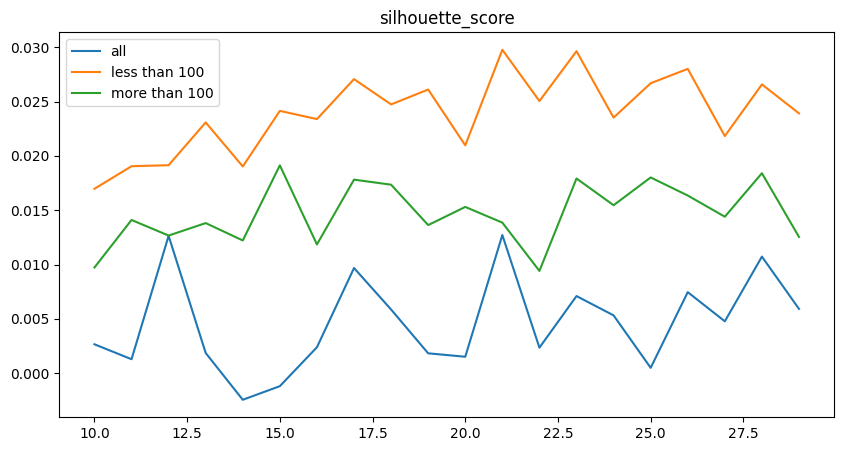

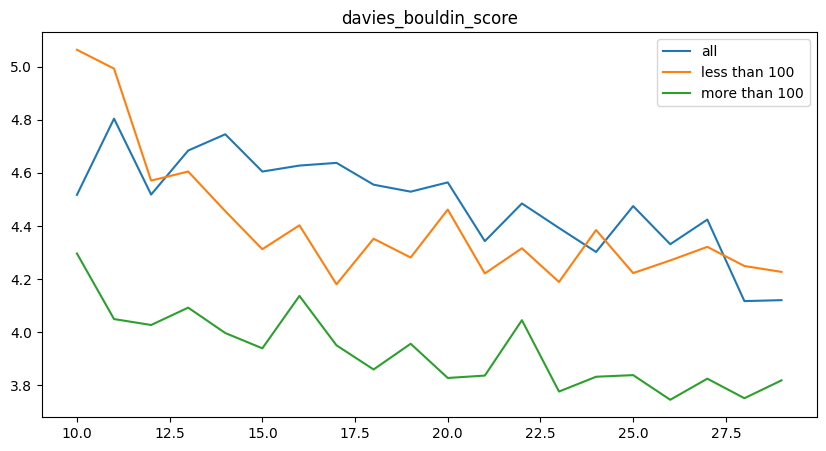

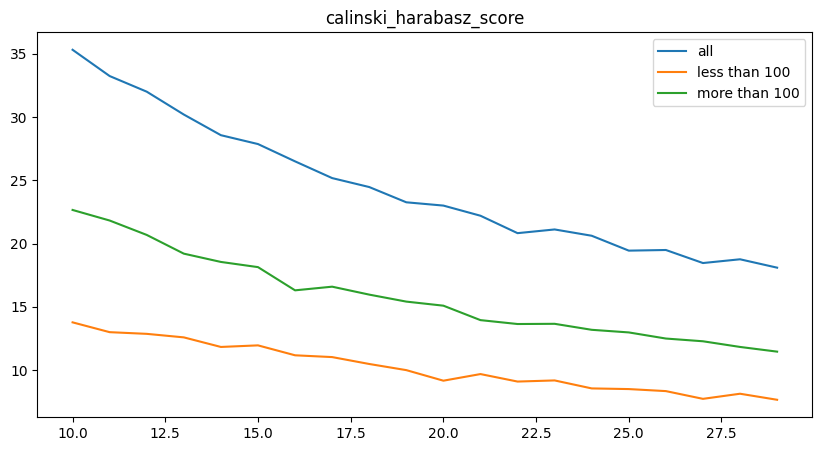

In [6]:
plot_attributes = ["inertia", "silhouette_score", "davies_bouldin_score", "calinski_harabasz_score"]
labels = ["all", "less than 100", "more than 100"]
for attribute in plot_attributes:
    plt.figure(figsize=(10, 5))
    for i, df_corpus in enumerate(df_corporas):
        plt.plot(cluster_sizes, [m[attribute] for m in measures[i]], label=labels[i])
        plt.title(attribute)
    plt.legend()
    plt.savefig(f"figures/emb_baseline_measure_{attribute}.png")
    plt.show()